# SkimLit 📄🔥

The purpose of this notebook is to build an NLP model to make reading medical abstract easier.

The paper we're replicating (the source of the datset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see the model architecture that they use to achieve their best results is available here.


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-52732dc5-3360-5133-06e0-ce92e6d33bd2)


## Get Data 
Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used 
We can do so from the author's Github:
http://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
!git clone http://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rctjjjj

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
ls: cannot access 'pubmed-rctjjjj': No such file or directory


In [ ]:
# Check what files are in the pubmed 20k dataset 
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/


dev.txt  test.txt  train.txt


In [ ]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
import os 
filenames = [data_dir + filename for filename in os.listdir(data_dir)]

In [ ]:
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

Now we've got some text data. It's time to become one with it.
And one of the best ways to become one with the data is to...

> Visualize, visualize, visualize

So with that in mind let's write a function to read in all the lines of a target text file.

In [ ]:
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
  filename: a string containing the target filepath.

  returns:
  A list of strings with one string per line from the target filename.
  """
  with open(filename, 'r') as f:
    return f.readlines()

In [ ]:
# Let's read in the training lines 
train_lines = get_lines(data_dir + 'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Let's think about how we want our data to look...

How I think our data would be best represented...
```
[{'line_number':0,
 'target': background, 
 'text':The aim of this study was to test if attention bias for food moderates the effect of self-reported emotional eating during sad mood ( vs neutral mood ) on actual food intake.\n,
'total_lines':11}...]
```

In [ ]:
print(train_lines[:2])

['###24293578\n', 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n']


In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of filenames of abstract line data .
  Takes in filename, reads it contents and sorts through each line, 
  extracting things like target label, the text of the sentence,
   how many sentences are in the current abstract and what sentence number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from file name
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # creates an empty list of abstracts

  # loop through each line in the target file
  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_lines = "" # reset the variable if the line is an ID line
    elif line.isspace(): # check to see if the line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from the text
        line_data['target'] = target_text_split[0]
        line_data['text']  = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split) - 1 # how many total lines are there in the target 
        abstract_samples.append(line_data) # add line data to abstract samples list
    else:
      abstract_lines += line

  return abstract_samples

In [ ]:
# Get data from file and preprocess it

%%time
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')
print(len(train_samples), len(val_samples),)

180040 30212
CPU times: user 637 ms, sys: 123 ms, total: 760 ms
Wall time: 887 ms


## Now that our data is in the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize our data

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
train_df.head(17)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribuition of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

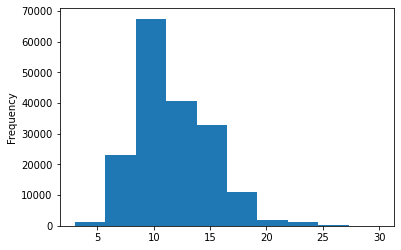

In [ ]:
# Lets check the length of different lines
train_df.total_lines.plot(kind='hist')

### Get lists of sentences 

In [ ]:
# convert abstract text lines into lists
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()


## Make numeric labels (ML models requires numeric labels)

In [ ]:
# One hot encode labels 
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want a non sparse matrix

train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [ ]:
# Extract labels ('target' columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_label_encoded = label_encoder.transform(test_df['target'].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from labelEncoder instances
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Strating a series of modelling experiments...

As usual, we're going to be trying out a bunch of different models and seeing which one works best.

And as always, we're going to start with a baseline (TF-IDF Multinomial Naive Bayes classifier)

## Model 0: getting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([("tfidf",TfidfVectorizer()), ('clf',MultinomialNB())
])

# Fit the pipeline to our trainiing data
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model on validation set 
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)

In [ ]:
### Download helper function script 

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-12-30 17:50:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-12-30 17:50:31 (80.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text) for deep sequences models

Before we starrt building deeper models, we've got to create vectorization and embedding layers

In [ ]:
import numpy as np
from tensorflow.keras import layers
import tensorflow as tf

In [ ]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

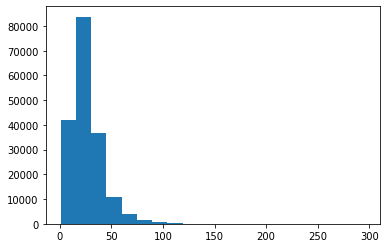

In [ ]:
# What's the distributiion looks like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [ ]:
# How long  of a sentence covers 90 percent of the examples?
output_seq_len = int(np.percentile(sent_lens, 95))

In [ ]:
output_seq_len

55

In [ ]:
# Max sequence length in Training set?
max(sent_lens)

296

## Create  Text Vectorizer layer

We want to make a layer which maps out texts from text to numbers.

In [ ]:
max_tokens = 68000

In [ ]:
# Crete text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text:{len(target_sentence.split())}")
print(f"\nVectorized text:{text_vectorizer([target_sentence])}")


Text:
novel ala made no difference in the likelihood of new malignancies developing .

Length of text:13

Vectorized text:[[ 741 4130 1050   33   74    5    2 1927    4  319 5128 1467    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most commom words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab:{rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most commom words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab:['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer 
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [ ]:
### Create custom text embedding
from tensorflow.keras import layers
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                               output_dim= 128,
                               mask_zero=True, # use masking to handle variable sequence lengths
                               name='token_embedding')

In [ ]:
print(f"Sentences before vectorization: \n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:{embedded_sentence}")
print(f"Embedding sentence shape:{embedded_sentence.shape}")

Sentences before vectorization: 
novel ala made no difference in the likelihood of new malignancies developing .

Sentence after vectorization (before embedding):
 [[ 741 4130 1050   33   74    5    2 1927    4  319 5128 1467    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:[[[ 0.04045321 -0.00908769  0.03786241 ...  0.03498072  0.03560324
    0.02057284]
  [ 0.00328315 -0.04676604 -0.04179224 ... -0.04836416  0.01383359
    0.0299523 ]
  [-0.03631966  0.00763416  0.00876992 ... -0.03840371  0.01025264
   -0.00368547]
  ...
  [-0.00738131  0.01298975  0.0094034  ... -0.01077398 -0.0199465
    0.02724074]
  [-0.00738131  0.01298975  0.0094034  ... -0.01077398 -0.0199465
    0.02724074]
  [-0.00738131  0.01298975  0.0094034  ... -0.01077398 -0.0199465
    0.02724074]]]
Embedding sentence sha

## Creating datasets ( making sure our data loads as fast as possible)
We're going to setup our data to run as ffast as possible wiht the tensorflow tf.data API, many of the steps are discussed at length on tensorflow.

In [ ]:
# Creating efficient data pipelines is basically one of the first steps we're going to do for every machine learning projects.
# Turn our data into Tensorflow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))


In [ ]:
# Take the Tensor Slices and turn them into prefetch
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [ ]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings  = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same',activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.5*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.5*len(valid_dataset))) # only validate on 10% of the batches

Epoch 1/3
2813/2813 [==============================] - 33s 9ms/step - loss: 0.6752 - accuracy: 0.7503 - val_loss: 0.5554 - val_accuracy: 0.8039
Epoch 2/3
2813/2813 [==============================] - 26s 9ms/step - loss: 0.5517 - accuracy: 0.8036 - val_loss: 0.5261 - val_accuracy: 0.8129
Epoch 3/3
   1/2813 [..............................] - ETA: 2:45 - loss: 0.6597 - accuracy: 0.7500

2813/2813 [==============================] - 1s 478us/step - loss: 0.6597 - accuracy: 0.7500 - val_loss: 0.5272 - val_accuracy: 0.8132


In [ ]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5343 - accuracy: 0.8107


[0.5342984199523926, 0.8107043504714966]

In [ ]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[5.96864700e-01, 8.10838640e-02, 7.27123395e-02, 2.00836122e-01,
         4.85029966e-02],
        [5.55862486e-01, 1.96094647e-01, 1.01604760e-02, 2.15034738e-01,
         2.28477158e-02],
        [2.17993483e-01, 5.61710261e-03, 1.05252548e-03, 7.75279939e-01,
         5.70000047e-05],
        ...,
        [4.39677660e-06, 1.52600580e-04, 1.28027599e-03, 5.85585076e-06,
         9.98556912e-01],
        [1.08866386e-01, 4.30879772e-01, 1.12241611e-01, 8.94519091e-02,
         2.58560300e-01],
        [3.61664966e-02, 9.38724577e-01, 1.82275176e-02, 1.41160679e-03,
         5.46974363e-03]], dtype=float32), (30212, 5))

In [ ]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_1_results = calculate_results(val_labels_encoded, model_1_preds)

In [ ]:
model_1_results

{'accuracy': 81.07043558850788,
 'precision': 0.8082772006744854,
 'recall': 0.8107043558850788,
 'f1': 0.8069971424264217}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature extraction with pretrained token embeddings

Now let's use pretrained word embeddings from Tensorflow hub, more specifically the univeral sentence encoder.

The paper originally useedd glove embeddings, however we're going to stick with the with the later created USE pretrained embeddings.

In [ ]:
# Download pretrained Tensorflow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',trainable=False, name='universal_sentence_encoder')

In [ ]:
random_train_sentence = random.choice(train_sentences)
print(f"Random_sentence:\n{random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence  embedding:{len(use_embedded_sentence[0])}")

Random_sentence:
however , a definitive difference in the addition of placebo to latanoprost was not identified in the trough level .
Sentence after embedding:
[ 0.04006493 -0.00097627 -0.00597398 -0.07457861 -0.05654409  0.06844269
  0.01415455 -0.0310682   0.03990296  0.08355784  0.06084087  0.00948356
  0.05536253  0.05368445  0.01804074  0.04126891 -0.04336141 -0.05761079
 -0.02635906 -0.04686507  0.0450032   0.06491691 -0.06293784  0.04684771
 -0.07634635  0.01314782  0.01819516 -0.04016696  0.08425198 -0.0313388 ]

Length of sentence  embedding:512


## Building and fitting an NLP feature extraction model using pretrained embeddinsg Tensorflow hub

In [ ]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embeddings
x = layers.Dense(128, activation = 'relu')(pretrained_embedding)
# Note: You could add more layers if you wanted to
outputs = layers.Dense(5, activation='softmax')(x)

model_2 = tf.keras.Model(inputs, outputs, name = 'model_2_USE_feature_extractor')

# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.5*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.5*len(valid_dataset),
                                                   ))

Epoch 1/3
2813/2813 [==============================] - 35s 12ms/step - loss: 0.7778 - accuracy: 0.7014 - val_loss: 0.6983 - val_accuracy: 0.7344
Epoch 2/3
2813/2813 [==============================] - 45s 16ms/step - loss: 0.6844 - accuracy: 0.7393 - val_loss: 0.6567 - val_accuracy: 0.7475
Epoch 3/3
   1/2813 [..............................] - ETA: 40s - loss: 0.7880 - accuracy: 0.6250

2813/2813 [==============================] - 4s 2ms/step - loss: 0.7880 - accuracy: 0.6250 - val_loss: 0.6566 - val_accuracy: 0.7476


In [ ]:
# Evaluate on the whole dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 15s 16ms/step - loss: 0.6579 - accuracy: 0.7487


[0.6579428315162659, 0.7487422227859497]

In [ ]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)

945/945 [==============================] - 14s 15ms/step


In [ ]:
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 0, ..., 4, 4, 1])>

In [ ]:
model_2_results = calculate_results(val_labels_encoded, model_2_preds)

In [ ]:
model_2_results

{'accuracy': 74.87422216337879,
 'precision': 0.7438110721473576,
 'recall': 0.7487422216337879,
 'f1': 0.7440081888561589}

## Model 3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings.

Previously, we've made token level encodings but we'll need to use similar steps for characters if we want to use char-level embeddings.

### Creating a character level tokenizer

In [ ]:
# Make a function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'h o w e v e r   ,   a   d e f i n i t i v e   d i f f e r e n c e   i n   t h e   a d d i t i o n   o f   p l a c e b o   t o   l a t a n o p r o s t   w a s   n o t   i d e n t i f i e d   i n   t h e   t r o u g h   l e v e l   .'

In [ ]:
# Split sequence-level data splits into character level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [ ]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

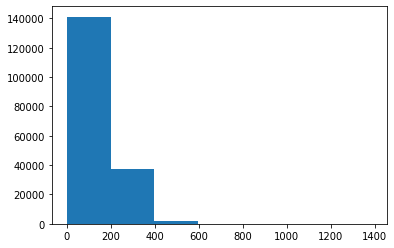

In [ ]:
# Check the distribution of our sequences at a character level
import matplotlib.pyplot
plt.hist(char_lens, bins=7)

In [ ]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV (out of vocab)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    standardize='lower_and_strip_punctuation',
                                    output_sequence_length=output_seq_char_len,
                                    name='char_vectorizer')

In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats
char_vocab  = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common vacab: {char_vocab[:5]}")
print(f"5 least common vacab: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common vacab: ['', '[UNK]', 'e', 't', 'i']
5 least common vacab: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"Length of random train chars: {len(random_train_chars)}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorizeed chars: {len(vectorized_chars[0])}") 

Charified text:
i n c r e a s e d   l e v e l s   o f   r e a c t i v e   o x y g e n   s p e c i e s   d u r i n g   a n d   a f t e r   s u r g e r y   m a y   a f f e c t   i n f l a m m a t o r y   r e s p o n s e   ,   p o s t - o p e r a t i v e   a d h e s i o n   m o l e c u l e   f o r m a t i o n   ,   a n d   h e m o d y n a m i c   s t a b i l i t y   .
Length of random train chars: 351
Vectorized chars:
 [[ 4  6 11  8  2  5  9  2 10 12  2 21  2 12  9  7 17  8  2  5 11  3  4 21
   2  7 24 19 18  2  6  9 14  2 11  4  2  9 10 16  8  4  6 18  5  6 10  5
  17  3  2  8  9 16  8 18  2  8 19 15  5 19  5 17 17  2 11  3  4  6 17 12
   5 15 15  5  3  7  8 19  8  2  9 14  7  6  9  2 14  7  9  3  7 14  2  8
   5  3  4 21  2  5 10 13  2  9  4  7  6 15  7 12  2 11 16 12  2 17  7  8
  15  5  3  4  7  6  5  6 10 13  2 15  7 10 19  6  5 15  4 11  9  3  5 22
   4 12  4  3 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

## Creating a character-level embedding

In [ ]:
# Create a char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25, # This is the size in the char embedding in the paper
                              mask_zero=True,
                              name='char_embed')

In [ ]:
random_train_char = random.choice(train_chars)
print(f"Charified Text: {random_train_char}\n")
char_embed_example = char_embed(char_vectorizer([random_train_char]))
print(f"after vectorization and embedding:\n{char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified Text: t h e r e   w e r e   s t a t i s t i c a l l y   s i g n i f i c a n t   i m p r o v e m e n t s   i n   l i p i d   p a r a m e t e r s   ,   g l y c e m i c   i n d i c a t o r s   ,   q u a l i t y - o f - l i f e   m e a s u r e s   ,   a n d   v i t a l   s i g n s   i n   t h e   l o r c a s e r i n   g r o u p   c o m p a r e d   w i t h   p l a c e b o   .

after vectorization and embedding:
[[[-3.4005024e-02 -2.3054898e-02  4.7376458e-02 ...  1.3224568e-02
   -3.6505617e-02 -4.2140830e-02]
  [-1.7506670e-02  5.8452860e-03  5.2072108e-05 ...  3.8445305e-02
    3.2619957e-02 -4.7932830e-02]
  [ 9.9221580e-03 -2.7807331e-02  1.8593479e-02 ... -2.7789999e-02
   -6.0849302e-03 -4.2078685e-02]
  ...
  [-2.7495300e-02  9.8292939e-03  2.6925121e-02 ... -4.3739177e-02
    4.0694062e-02 -2.5597990e-02]
  [-2.7495300e-02  9.8292939e-03  2.6925121e-02 ... -4.3739177e-02
    4.0694062e-02 -2.5597990e-02]
  [-2.7495300e-02  9.8292939e-03  2.6925121e-02 ... -4.3739177e-02
  

## Building a Conv1D model to fit on character embeddings

In [ ]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same',activation='relu')(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_3 = tf.keras.Model(inputs, outputs, name = 'model_3_cov1D_char_embeddings')

# compile
model_3.compile(loss='categorical_crossentropy',\
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_3.summary()

Model: "model_3_cov1D_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5

In [ ]:
# Create char level datasets 
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 1.2636 - accuracy: 0.4928 - val_loss: 1.0416 - val_accuracy: 0.5944
Epoch 2/3
562/562 [==============================] - 4s 6ms/step - loss: 0.9977 - accuracy: 0.6038 - val_loss: 0.9381 - val_accuracy: 0.6336
Epoch 3/3
562/562 [==============================] - 4s 6ms/step - loss: 0.9243 - accuracy: 0.6342 - val_loss: 0.8651 - val_accuracy: 0.6632


In [ ]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)

945/945 [==============================] - 3s 3ms/step


In [ ]:
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 4, 1])>

In [ ]:
model_3_results = calculate_results(val_labels_encoded, model_3_preds)

In [ ]:
model_3_results

{'accuracy': 65.50377333509864,
 'precision': 0.6489779925855204,
 'recall': 0.6550377333509864,
 'f1': 0.6436733964465825}

## Model 4: Combining a pretrained token embedding + character embedding (hybrid embedding layer)

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level embedding model (similar to `model_3` with a slight modification)
3. Combine 1 and 2 with a concatenate layer (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 in section 4.2 of pubmed.
5. Construct a model which takes token and character level sequences as inputs and produces sequence label probabilities as output.

In [ ]:
# 1. Setup the token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model= tf.keras.Model(token_inputs, token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output, char_model.output])

# 4. Create output layers - adding in Dropout, discussed in the pubmed paper
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Consstruct model with char and token inputs 
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input], outputs=output_layer,
                         name='model_4_token_and_char_embedding')


In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['

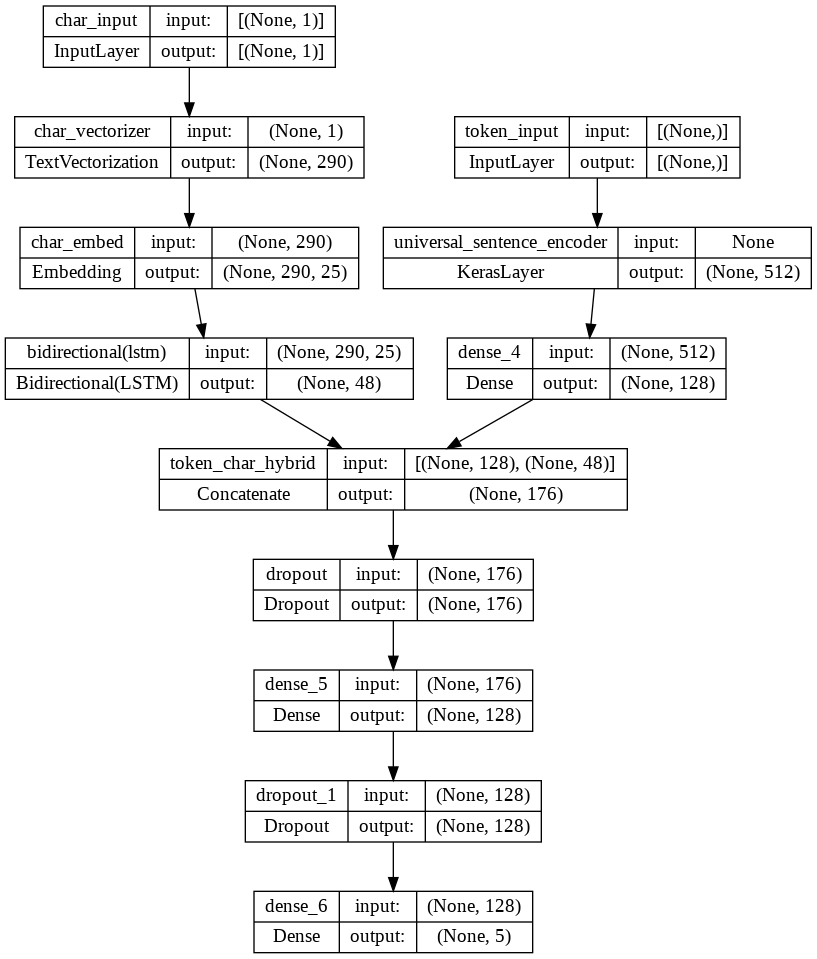

In [ ]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)


`Airbnb WideText: A multimodel Deep Learning learning Framework`

In [ ]:
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

## Combining token and character data into a tf.data  Dataset

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              validation_data=val_char_token_dataset,
                              validation_steps = int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 53s 74ms/step - loss: 0.9787 - accuracy: 0.6132 - val_loss: 0.7771 - val_accuracy: 0.7035
Epoch 2/3
562/562 [==============================] - 36s 64ms/step - loss: 0.8032 - accuracy: 0.6882 - val_loss: 0.7166 - val_accuracy: 0.7271
Epoch 3/3
562/562 [==============================] - 27s 49ms/step - loss: 0.7861 - accuracy: 0.7001 - val_loss: 0.7225 - val_accuracy: 0.7307


In [ ]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 28s 30ms/step - loss: 0.7306 - accuracy: 0.7234


[0.7306469082832336, 0.7233549356460571]

In [ ]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)

945/945 [==============================] - 28s 26ms/step


In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)

In [ ]:
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
model_4_results = calculate_results(val_labels_encoded, model_4_preds)

In [ ]:
model_4_results

{'accuracy': 72.33549582947172,
 'precision': 0.7306116332941612,
 'recall': 0.7233549582947173,
 'f1': 0.722843253534035}

## Feature Engineering 

- Taking non-obvious features form the data and encoding them numerically to help our model learn.
- How can we add extra soures of data to our model?


## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


> 🔑**Note:** Any engineered features used to train a model need to be available at Test time.

### Create positional embeddings

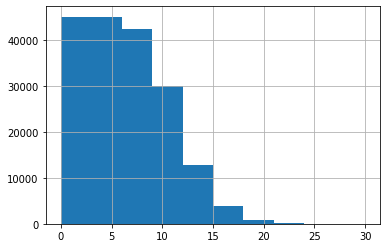

In [ ]:
# How many different line numbers are there
train_df['line_number'].hist()

In [ ]:
np.percentile(train_df['line_number'], 95)

13.0

In [ ]:
# Use Tensorflow to create one hot encoded tensors for our 'line number' column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

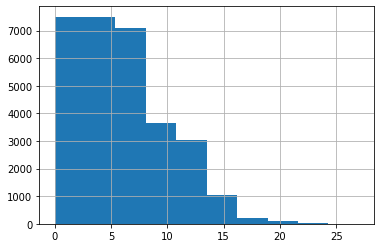

In [ ]:
test_df['line_number'].hist()

In [ ]:
np.percentile(val_df['line_number'], 95)

13.0

In [ ]:
np.percentile(test_df['line_number'], 95)

13.0

In [ ]:
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

 Now we've encodeed our line numbers feature, let's do the same for our total lines features

In [ ]:
# How many different number of lines are there
np.percentile(train_df['total_lines'], 95)

18.0

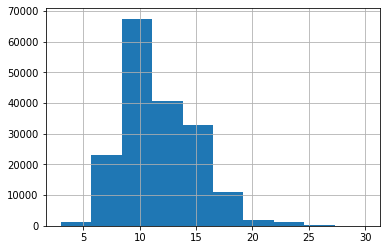

In [ ]:
# Check the distributions of total lines
train_df.total_lines.hist()

In [ ]:
# Use Tensorflow to create one-hot-encoded tensors of our 'total_lines' feature
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(),depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(),depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(),depth=20)

### Building a tribrid embeddingg layer

1. Create a token-level model
2. Create a character-level model
3. Create a model for the 'line_number' feature
4. Create a model for the 'total_lines' feature
5. Combine the outputs of 1 and 2 using tf.keras.Concatenate
6. Combine the outputs of 3,4,5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1,2,3,4 and outputs of 7 into tf.keras.Model

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)
     

In [ ]:
# Get a summary of our tribrid embedding model
model_5.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

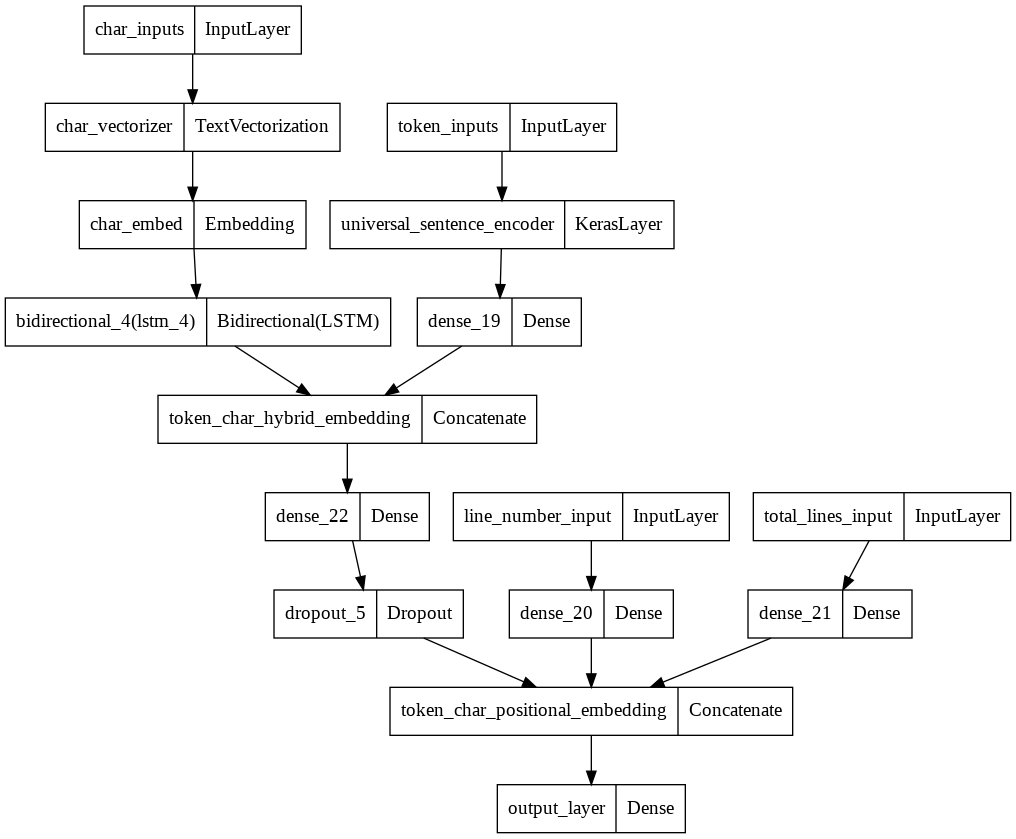

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

What is label smoothing?

for example if our model gets too confident on a single class (e.g. it's
prediction probability is really high), it may get stuck on that class 
and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the value form the highest pred prob 
to other classes, in turn, hopefully improving generalization:`[0.01,0.01,0.96,0.01,0.01]`



In [ ]:
# Compile tribrid model 

model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:

# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 36s 49ms/step - loss: 1.0922 - accuracy: 0.7256 - val_loss: 0.9806 - val_accuracy: 0.8072
Epoch 2/3
562/562 [==============================] - 26s 46ms/step - loss: 0.9666 - accuracy: 0.8172 - val_loss: 0.9474 - val_accuracy: 0.8278
Epoch 3/3
562/562 [==============================] - 23s 41ms/step - loss: 0.9486 - accuracy: 0.8231 - val_loss: 0.9387 - val_accuracy: 0.8324


In [ ]:
model_5.evaluate(val_pos_char_token_dataset)

945/945 [==============================] - 20s 22ms/step - loss: 0.9369 - accuracy: 0.8332


[0.9369280934333801, 0.8332119584083557]

In [ ]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)

945/945 [==============================] - 35s 33ms/step


In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)

In [ ]:
model_5_results = calculate_results(val_labels_encoded, model_5_preds)

In [ ]:
model_5_results

{'accuracy': 83.32119687541373,
 'precision': 0.8325108053096208,
 'recall': 0.8332119687541374,
 'f1': 0.8326200452111767}

## Compare model results

In [ ]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                 "model_1_token_embedding": model_1_results,
                                 "model_2_pretrained_token_embedding": model_2_results,
                                 "model_3_custom_char_embedding":model_3_results,
                                 "model_4_hybrid_char_token_embedding":model_4_results,
                                 "model_5_pos_char_token_embedding":model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_token_embedding,81.070436,0.808277,0.810704,0.806997
model_2_pretrained_token_embedding,74.874222,0.743811,0.748742,0.744008
model_3_custom_char_embedding,65.503773,0.648978,0.655038,0.643673
model_4_hybrid_char_token_embedding,72.335496,0.730612,0.723355,0.722843
model_5_pos_char_token_embedding,83.321197,0.832511,0.833212,0.832620


In [ ]:
# Reduce the accuracy to same scale as other models
all_model_results['accuracy'] = all_model_results['accuracy']/100

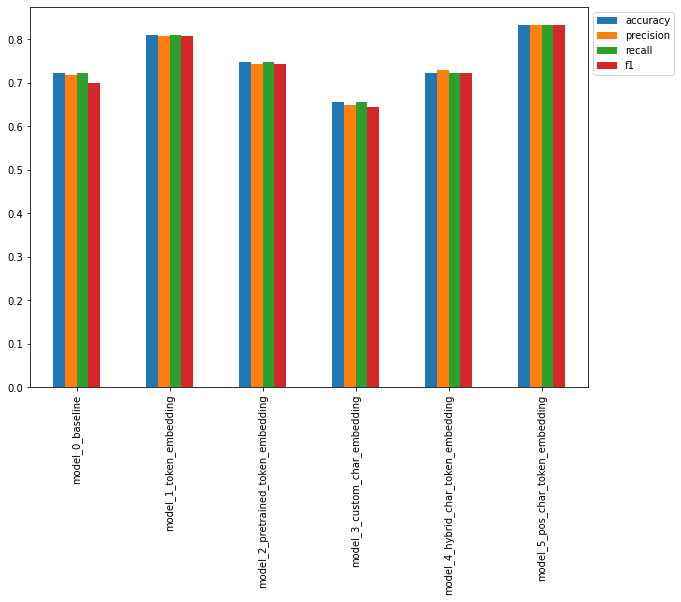

In [ ]:
# Plot and compare all model results
all_model_results.plot(kind='bar',figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

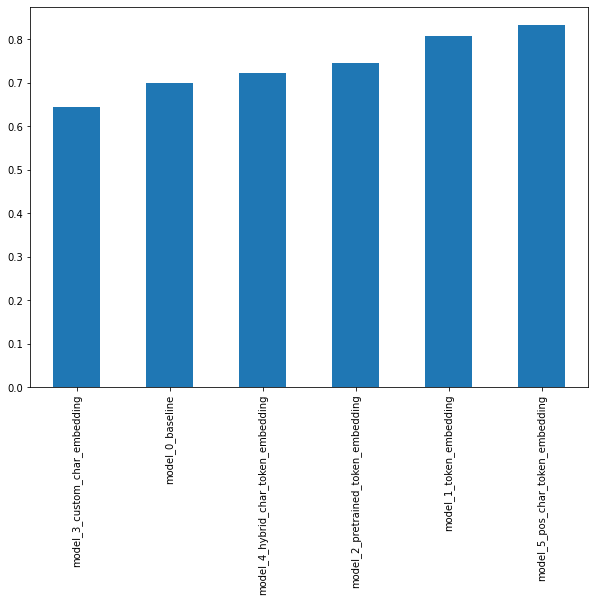

In [ ]:
# Sort models results by f1-score
all_model_results.sort_values('f1', ascending=True)['f1'].plot(kind='bar',figsize=(10,7))